Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 3.01
RMSE: 6.26
R2 Score: 0.97
               Feature  Importance
5      DEPARTURE_DELAY    0.875196
9         ELAPSED_TIME    0.055273
8       SCHEDULED_TIME    0.045966
3  SCHEDULED_DEPARTURE    0.004648
1       ORIGIN_AIRPORT    0.003915
7         ARRIVAL_TIME    0.003564
2  DESTINATION_AIRPORT    0.003277
4       DEPARTURE_TIME    0.003218
6    SCHEDULED_ARRIVAL    0.002818
0              AIRLINE    0.002126


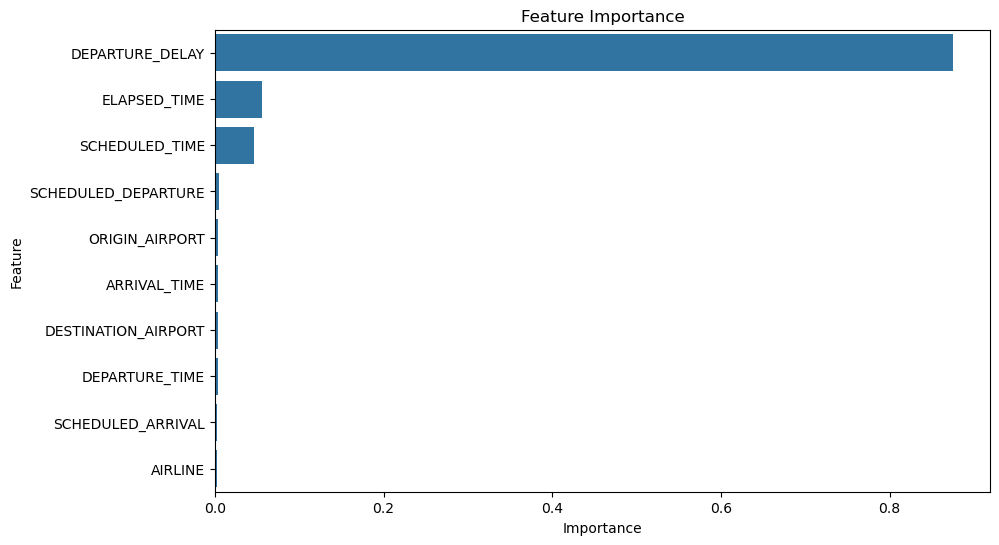

Model saved as 'flight_delay_regressor.pkl'


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
file_path = '../data/cleaned_flights.csv'
data = pd.read_csv(file_path)

# Take only 20000 rows for faster processing
data = data.sample(n=20000, random_state=42)

# Drop rows with missing target
data = data.dropna(subset=['ARRIVAL_DELAY'])

# Remove wheels off/on columns if present
wheels_cols = [
    'WHEELS_OFF_HOUR', 'WHEELS_OFF_MIN', 'WHEELS_ON_HOUR', 'WHEELS_ON_MIN'
]
for col in wheels_cols:
    if col in data.columns:
        data = data.drop(columns=[col])

# Select features and target
target_column = 'ARRIVAL_DELAY'
drop_cols = [target_column]
if 'DATE' in data.columns:
    drop_cols.append('DATE')
X = data.drop(columns=drop_cols)

# Encode categorical variables
label_encoders = {}
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Save label encoders for future use
joblib.dump(label_encoders, 'label_encoders.pkl')

y = data[target_column]

# Optimize data types
for col in X.select_dtypes(include=['int64', 'float64']).columns:
    X[col] = X[col].astype('float32')

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Hyperparameter tuning (optional, can be commented for quick runs)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")

# Train final model
model = grid_search.best_estimator_
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Feature importance
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("Feature Importance")
plt.show()

# Save the model
joblib.dump(model, 'flight_delay_regressor.pkl')
print("Model saved as 'flight_delay_regressor.pkl'")



In [13]:
# Example input likely to produce a high delay prediction
input_data= {
    'YEAR': [2021],
    'MONTH': [12],           # December (winter, often more delays)
    'DAY': [24],             # Busy holiday travel day
    'DAY_OF_WEEK': [7],      # Sunday
    'FLIGHT_NUMBER': [4500], # Use a valid flight number from your dataset
    'TAIL_NUMBER': ['N999ZZ'],
    'AIRLINE': ['UA'],       # United Airlines (example)
    'ORIGIN_AIRPORT': ['ORD'], # Chicago O'Hare (busy, weather-prone)
    'DESTINATION_AIRPORT': ['JFK'], # New York JFK (busy)
    'DISTANCE': [74000],       # ORD-JFK distance
    'SCHED_DEP_HOUR': [22],  # 10 PM (late, more likely to be delayed)
    'SCHED_DEP_MIN': [45],
    'DEP_HOUR': [23],        # Actual departure even later
    'DEP_MIN': [30],
    'DEPARTURE_DELAY': [45], # Already a big departure delay
    'SCHED_ARR_HOUR': [1],   # Scheduled arrival after midnight
    'SCHED_ARR_MIN': [0],
    'ARR_HOUR': [2],         # Actual arrival even later
    'ARR_MIN': [10],
    'SCHEDULED_TIME': [180], # 3 hours scheduled
    'CANCELLATION_REASON': ['None'],
}

sample_df = pd.DataFrame(input_data)

# Encode categorical columns
for col, le in label_encoders.items():
    if col in sample_df.columns:
        sample_df[col] = le.transform(sample_df[col].astype(str))

# Ensure all columns are present and in the correct order
for col in model.feature_names_in_:
    if col not in sample_df.columns:
        sample_df[col] = 0
sample_df = sample_df[model.feature_names_in_]

# Predict arrival delay
predicted_delay = float(model.predict(sample_df)[0])

# Convert delay to hours and minutes
delay_hours = int(predicted_delay // 60)
delay_minutes = int(predicted_delay % 60)

# Delay status logic
if predicted_delay < 0:
    delay_status = "Early Arrival"
elif predicted_delay == 0:
    delay_status = "On Time"
elif predicted_delay <= 15:
    delay_status = "Short Delay"
elif predicted_delay <= 45:
    delay_status = "Moderate Delay"
else:
    delay_status = "Significant Delay"

origin = input_data['ORIGIN_AIRPORT'][0]
destination = input_data['DESTINATION_AIRPORT'][0]
distance = input_data.get('DISTANCE', 0)
print(f"Distance: {distance} miles")  # Will be None if not provided

print(f"From {origin} to {destination}")
print(f"Predicted Delay: {delay_hours} hour(s) {delay_minutes} minute(s)")
print(f"Delay Status: {delay_status}")
# Save the model
joblib.dump(model, 'flight_delay_regressor.pkl')
print("Model saved as 'flight_delay_regressor.pkl'")

Distance: [74000] miles
From ORD to JFK
Predicted Delay: 0 hour(s) 26 minute(s)
Delay Status: Moderate Delay
Model saved as 'flight_delay_regressor.pkl'


In [14]:
# Only use these fields for input
input_data = {
    'YEAR': [2015],
    'MONTH': [12],
    'DAY': [24],
    'FLIGHT_NUMBER': [4500],
    'TAIL_NUMBER': ['N999ZZ'],
    'AIRLINE': ['UA'],
    'ORIGIN_AIRPORT': ['ORD'],
    'DESTINATION_AIRPORT': ['JFK'],
    'DISTANCE': [740],
    'SCHED_DEP_HOUR': [22],
    'SCHED_DEP_MIN': [45]
}

sample_df = pd.DataFrame(input_data)

# Encode categorical columns
for col, le in label_encoders.items():
    if col in sample_df.columns:
        sample_df[col] = le.transform(sample_df[col].astype(str))

# Ensure all columns are present and in the correct order
for col in model.feature_names_in_:
    if col not in sample_df.columns:
        sample_df[col] = 0
sample_df = sample_df[model.feature_names_in_]

# Predict arrival delay
predicted_delay = float(model.predict(sample_df)[0])

# Convert delay to hours and minutes
delay_hours = int(predicted_delay // 60)
delay_minutes = int(predicted_delay % 60)

# Delay status logic
if predicted_delay < 0:
    delay_status = "Early Arrival"
elif predicted_delay == 0:
    delay_status = "On Time"
elif predicted_delay <= 15:
    delay_status = "Short Delay"
elif predicted_delay <= 45:
    delay_status = "Moderate Delay"
else:
    delay_status = "Significant Delay"

origin = input_data['ORIGIN_AIRPORT'][0]
destination = input_data['DESTINATION_AIRPORT'][0]
distance = input_data['DISTANCE'][0]
print(f"Distance: {distance} miles")
print(f"From {origin} to {destination}")
print(f"Predicted Delay: {delay_hours} hour(s) {delay_minutes} minute(s)")
print(f"Delay Status: {delay_status}")

Distance: 740 miles
From ORD to JFK
Predicted Delay: -1 hour(s) 59 minute(s)
Delay Status: Early Arrival
